# Copyright
<pre>
You may use and modify this code for research and development purpuses.
Using this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved

</pre>

In this notebook, we will classify human activities based on smartphone accelerometer and gyroscope data. The corresponding Human Activity Recognition Using Smartphones Data Set is delivered by UCI Machine Learning Repository, for more information [please visit the site](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones).

## 1. Data acquisition
Lets download and unpack the data.

In [1]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip

In [2]:
# !unzip "UCI HAR Dataset.zip" > null

## 2. Imports
In this notebook we will need the following packages.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling1D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

2024-04-10 23:10:15.237770: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 23:10:15.237797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 23:10:15.238144: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-10 23:10:15.241598: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 3. Loading the data
The following functions will load the training and test data from the unpacked dataset.

In [6]:
# this function loads a single file (input or output)
def load_file(filepath):
    df = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return df.values


# this function loads a set of files into a Numpy array with a shape of [samples, timesteps, features]
def load_group(filenames, prefix=""):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
        # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded


# load inputs and outputs from a directory
def load_XY(group, path):
    filepath = path + group + "/Inertial Signals/"
    filenames = list()
    filenames += (
        [
            "total_acc_x_" + group + ".txt",
            "total_acc_y_" + group + ".txt",
            "total_acc_z_" + group + ".txt",
        ]
        + [
            "body_acc_x_" + group + ".txt",
            "body_acc_y_" + group + ".txt",
            "body_acc_z_" + group + ".txt",
        ]
        + [
            "body_gyro_x_" + group + ".txt",
            "body_gyro_y_" + group + ".txt",
            "body_gyro_z_" + group + ".txt",
        ]
    )
    # inputs
    X = load_group(filenames, filepath)
    # output (class)
    Y = load_file(path + group + "/y_" + group + ".txt")
    return X, Y


# load the dataset, returns train and test X and y elements
def load_dataset(path="UCI HAR Dataset/"):
    # load all train
    X_train, Y_train = load_XY("train", path)
    X_test, Y_test = load_XY("test", path)
    Y_train = to_categorical(
        Y_train - 1
    )  # we need -1 to scale the categories between 0..5 (from 1..6)
    Y_test = to_categorical(
        Y_test - 1
    )  # we need -1 to scale the categories between 0..5 (from 1..6)
    return X_train, Y_train, X_test, Y_test

In [7]:
X_train, Y_train, X_test, Y_test = load_dataset()

In [8]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((7352, 128, 9), (7352, 6), (2947, 128, 9), (2947, 6))

In [9]:
Y_train[0],

(array([0., 0., 0., 0., 1., 0.], dtype=float32),)

In [10]:
X_train.shape

(7352, 128, 9)

## 3.1. Data exploration: target variable - exercise 1
Let's check how many data instances there are for each class:

In [11]:
number_of_instances = np.sum(Y_train, axis=0)

for i in range(6):
    print(f"No. of instance belong to class {i}:", number_of_instances[i])
# print("No. of instance belong to class 1:",len(<TODO>))
# print("No. of instance belong to class 2:",len(<TODO>))
# print("No. of instance belong to class 3:",len(<TODO>))
# print("No. of instance belong to class 4:",len(<TODO>))
# print("No. of instance belong to class 5:",len(<TODO>))

No. of instance belong to class 0: 1226.0
No. of instance belong to class 1: 1073.0
No. of instance belong to class 2: 986.0
No. of instance belong to class 3: 1286.0
No. of instance belong to class 4: 1374.0
No. of instance belong to class 5: 1407.0


You can doublecheck your calculations by plotting the histogram of the target variables:

<Axes: ylabel='Count'>

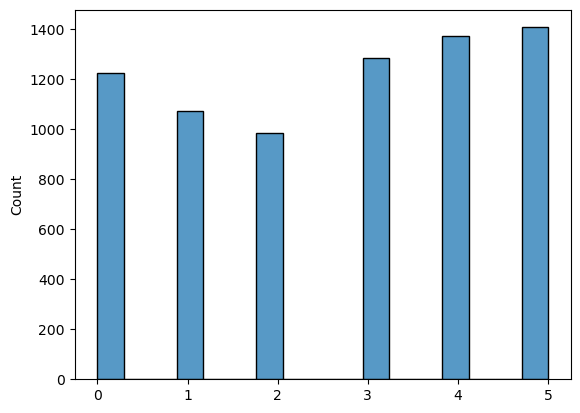

In [12]:
sns.histplot(np.argmax(Y_train, axis=1))

## 3.2. Data exploration: input variables - exercise 2
And now let's select one instance from each class and plot the corresponding timeseries:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


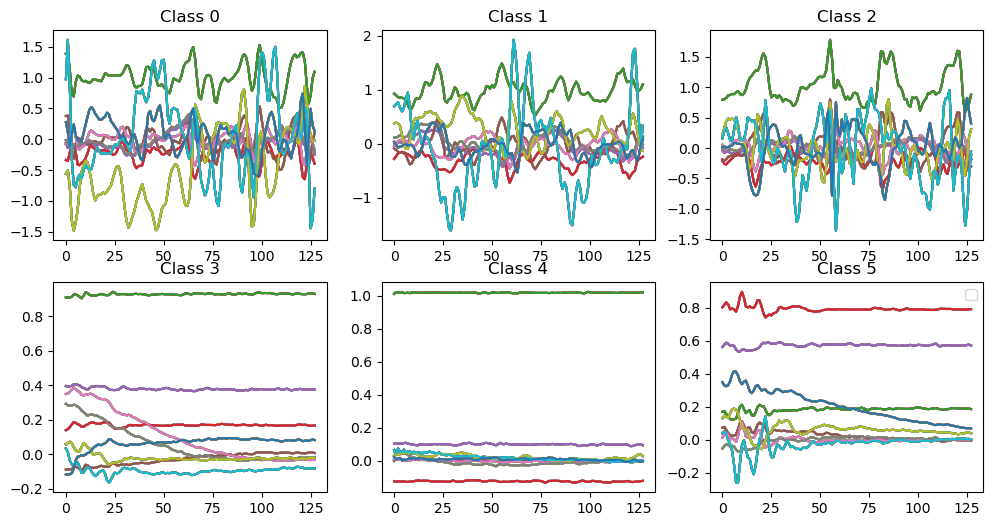

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for i in range(2):  # row
    for k in range(3):  # column
        for l in range(X_train.shape[2]):  # dimensons to be displayed
            class_no = i * 3 + k

            for idx in range(len(Y_train)):
                if np.argmax(Y_train[idx]) == class_no:
                    break

            axs[i, k].plot(X_train[idx])
            axs[i, k].title.set_text("Class " + str(class_no))
plt.legend()
plt.show()

## 4. Model definition and training - exercise 3

Let's define and train a 1D convolutional neural network, with the multidimensional timeseries as inputs, and the class in one-hot encoding as output.

This time your task is to correct the code below and achieve higher than 90% validation accuracy and test accuracy. The test accuracy is calculated in section 5.
Currently, **there are many errors (both syntactical and theroetical) in the model definition, compile and fit parts**, that should be fixed to achieve the goal. Don't change the number of layers and the layer types, and validation_split, just the other hyperparameters. There are several good solutions!

Hints:
* use narrow and deep Conv1D kernels
* use standard activation functions for the inner layers (e.g. relu, sigmoid, tanh) with the corresponding initialization method
* use the appropriate activation function the output and the corresponding loss function (which is aligned with the classification task)
* use regularization, but not too agressive
* use standard optimizers
* train in mini-batches

In [12]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(network_history.history["loss"])
    plt.plot(network_history.history["val_loss"])
    plt.legend(["Training", "Validation"])

    plt.figure()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.plot(network_history.history["accuracy"])
    plt.plot(network_history.history["val_accuracy"])
    plt.legend(["Training", "Validation"], loc="lower right")
    plt.show()

In [13]:
nb_filter = 5  # number of filter/kernels in the convolutional layers
filter_length = 30  # length of the filter/kernel in the convolutional layers
window_size = X_train.shape[1]  # the window size defined by the dataset
nb_features = X_train.shape[2]  # the number of features of the input data
nb_outputs = Y_train.shape[1]  # the number of outputs (defined by the target data)

In [14]:
tf.keras.backend.clear_session()
model = Sequential()

model.add(
    Conv1D(
        filters=50,
        kernel_size=5,
        activation="relu",
        kernel_initializer="he_normal",
        input_shape=(window_size, nb_features),
    )
)
model.add(MaxPooling1D())
model.add(Dropout(0.35))

model.add(
    Conv1D(
        filters=100,
        kernel_size=5,
        activation="relu",
        kernel_initializer="he_normal",
    )
)
model.add(MaxPooling1D())
model.add(Dropout(0.35))

model.add(Flatten())
model.add(Dense(256, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.35))

model.add(Dense(nb_outputs, activation="softmax"))

2024-04-10 21:17:03.534561: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 21:17:03.534741: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 21:17:03.551622: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Compiling the model with the appropriate loss function for multiclass classification.

In [15]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 124, 50)           2300      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 62, 50)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 50)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 58, 100)           25100     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 29, 100)          0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 29, 100)           0

In [17]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy")

And now we run the training:

In [18]:
network_history = model.fit(
    X_train,
    Y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,  # don't change the validation split
    callbacks=[es],
    verbose=2,
)

Epoch 1/200


2024-04-10 21:17:04.451269: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-10 21:17:05.233310: I external/local_xla/xla/service/service.cc:168] XLA service 0x73e9899968a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-10 21:17:05.233337: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-04-10 21:17:05.233340: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce GTX 1650 with Max-Q Design, Compute Capability 7.5
2024-04-10 21:17:05.237359: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712776625.290566    6336 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


184/184 - 3s - loss: 0.5937 - accuracy: 0.7570 - val_loss: 0.5135 - val_accuracy: 0.8960 - 3s/epoch - 16ms/step
Epoch 2/200
184/184 - 0s - loss: 0.2413 - accuracy: 0.9061 - val_loss: 0.4070 - val_accuracy: 0.9048 - 383ms/epoch - 2ms/step
Epoch 3/200
184/184 - 0s - loss: 0.1359 - accuracy: 0.9468 - val_loss: 0.3645 - val_accuracy: 0.9048 - 370ms/epoch - 2ms/step
Epoch 4/200
184/184 - 0s - loss: 0.1091 - accuracy: 0.9565 - val_loss: 0.3837 - val_accuracy: 0.9089 - 404ms/epoch - 2ms/step
Epoch 5/200
184/184 - 0s - loss: 0.1023 - accuracy: 0.9560 - val_loss: 0.4013 - val_accuracy: 0.9103 - 390ms/epoch - 2ms/step
Epoch 6/200
184/184 - 0s - loss: 0.0926 - accuracy: 0.9578 - val_loss: 0.3679 - val_accuracy: 0.9001 - 382ms/epoch - 2ms/step
Epoch 7/200
184/184 - 0s - loss: 0.0884 - accuracy: 0.9590 - val_loss: 0.3196 - val_accuracy: 0.9198 - 377ms/epoch - 2ms/step
Epoch 8/200
184/184 - 0s - loss: 0.0871 - accuracy: 0.9600 - val_loss: 0.4583 - val_accuracy: 0.9103 - 391ms/epoch - 2ms/step
Epoch 

val_accuracy: 0.9272603392601013
93/93 [==============================] - 0s 2ms/step - loss: 0.2454 - accuracy: 0.9301
Test loss: 0.24543018639087677
Test accuracy: 0.9300984144210815


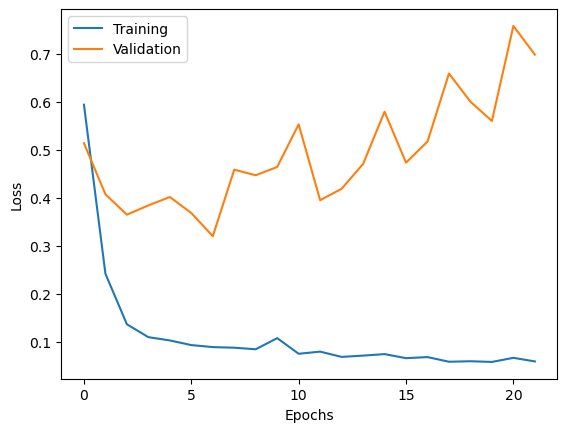

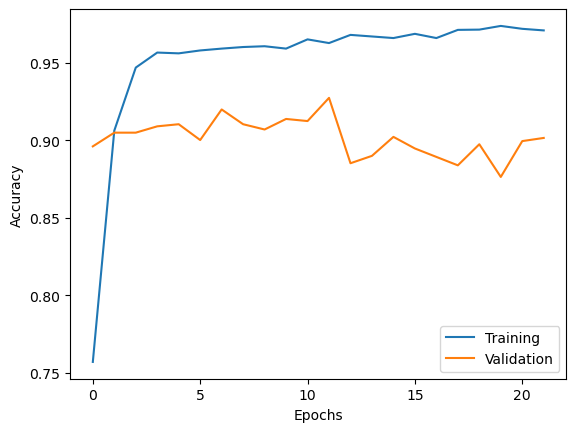

In [19]:
print("val_accuracy:", max(network_history.history["val_accuracy"]))
eval = model.evaluate(X_test, Y_test)
print("Test loss:", eval[0])
print("Test accuracy:", eval[1])
plot_history(network_history)

## 5. Evaluation
Please run the cells below to check the test loss and test accuracy (remember, the accuracy must be over 90%) and inspect the other evaluation methods as well.

In [20]:
eval = model.evaluate(X_test, Y_test)
print("Test loss:", eval[0])
print("Test accuracy:", eval[1])

93/93 [==============================] - 0s 1ms/step - loss: 0.2454 - accuracy: 0.9301
Test loss: 0.24543018639087677
Test accuracy: 0.9300984144210815


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
preds = model.predict(X_test)

93/93 [==============================] - 0s 793us/step


In [23]:
print(classification_report(np.argmax(Y_test, 1), np.argmax(preds, 1)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       496
           1       0.92      0.97      0.94       471
           2       0.97      0.99      0.98       420
           3       0.81      0.85      0.83       491
           4       0.90      0.82      0.86       532
           5       0.99      0.97      0.98       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



<Axes: >

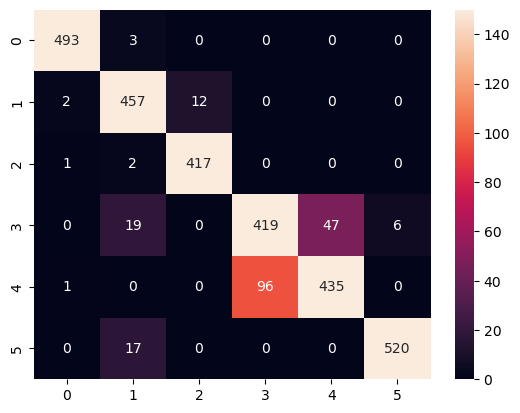

In [24]:
conf = confusion_matrix(np.argmax(Y_test, 1), np.argmax(preds, 1))
sns.heatmap(conf, annot=True, fmt="d", vmax=150)